# Document Classification Benchmark
Comparing Gemini Flash 2.5, Mistral OCR, and GPT-4o on document categorization and extraction tasks

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, f1_score
import requests
import zipfile
from pathlib import Path
import time
from dotenv import load_dotenv

from model import OpenRouterClient
from processor import DocumentProcessor


In [ ]:
# Setup
load_dotenv()
API_KEY = os.getenv('OPENROUTER_API_KEY')
client = OpenRouterClient(API_KEY)
processor = DocumentProcessor()

models_to_test = ['gemini-flash-2.5', 'gpt-4o']
results = {}

## Dataset Setup
Download and prepare test datasets

In [17]:
# Dataset setup: build test cases from any files placed in the `data/` directory
import base64
import mimetypes
from pathlib import Path

# Ensure data directory exists
Path('data').mkdir(exist_ok=True)


def file_to_test_case(p: Path):
    """Create a test case dict from a file path.
    - Images and PDFs are encoded as data URIs in `file_base64`.
    - Text files are read into `text`.
    - Other binaries fall back to `file_path` so downstream code can handle them.
    Category is set to the file stem by default.
    """
    mime, _ = mimetypes.guess_type(str(p))
    if mime is None:
        mime = 'application/octet-stream'

    if mime.startswith('image/') or mime == 'application/pdf':
        with open(p, 'rb') as f:
            b = f.read()
        b64 = base64.b64encode(b).decode()
        data_uri = f"data:{mime};base64,{b64}"
        return {'category': p.stem, 'file_base64': data_uri, 'expected_entities': {}}

    if mime.startswith('text/') or p.suffix.lower() in {'.txt', '.md', '.csv'}:
        with open(p, 'r', encoding='utf-8', errors='replace') as f:
            text = f.read()
        return {'category': p.stem, 'text': text, 'expected_entities': {}}

    # Fallback: provide file path for custom handling
    return {'category': p.stem, 'file_path': str(p), 'expected_entities': {}}


# Build test cases from files in data/
data_files = sorted([p for p in Path('data').iterdir() if p.is_file()])
test_cases = [file_to_test_case(p) for p in data_files]

## Model Benchmarking

In [5]:
def run_benchmark(model_name, test_cases):
    print(f"\nBenchmarking {model_name}...")
    
    predictions = []
    true_labels = []
    processing_times = []
    costs = []
    errors = 0
    
    for case in tqdm(test_cases, desc=f"Processing {model_name}"):
        try:
            start_time = time.time()
            result = client.classify_and_extract(
                text=case['text'], 
                image_base64=None, 
                model_name=model_name
            )
            
            predictions.append(result.category.value)
            true_labels.append(case['category'])
            processing_times.append(result.processing_time or 0)
            costs.append(result.cost or 0)
            
        except Exception as e:
            print(f"Error with {model_name}: {e}")
            predictions.append('other')
            true_labels.append(case['category'])
            processing_times.append(0)
            costs.append(0)
            errors += 1
            
        # Rate limiting
        time.sleep(1)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    avg_time = np.mean(processing_times)
    total_cost = sum(costs)
    error_rate = errors / len(test_cases)
    
    return BenchmarkResult(
        model_name=model_name,
        category_accuracy=accuracy,
        extraction_f1=f1,
        avg_processing_time=avg_time,
        total_cost=total_cost,
        samples_processed=len(test_cases),
        error_rate=error_rate
    ), predictions, true_labels

# Run benchmarks
benchmark_results = {}
all_predictions = {}
all_true_labels = {}

for model in models_to_test:
    try:
        result, preds, true_labs = run_benchmark(model, synthetic_test_cases)
        benchmark_results[model] = result
        all_predictions[model] = preds
        all_true_labels[model] = true_labs
    except Exception as e:
        print(f"Failed to benchmark {model}: {e}")


Benchmarking gemini-flash-2.5...


Processing gemini-flash-2.5: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]



Benchmarking mistral-ocr...


Processing mistral-ocr: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



Benchmarking gpt-4o...


Processing gpt-4o: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


In [11]:
results_df = pd.DataFrame([vars(result) for result in benchmark_results.values()])

## Results Analysis

In [ ]:
# Only generate demo base64 images if we don't already have test cases from `data/`.
import base64

if 'synthetic_test_cases' not in globals() or not synthetic_test_cases:
    from PIL import Image
    import io

    def create_test_image(color=(255, 255, 255)):
        img = Image.new('RGB', (100, 100), color)
        buffer = io.BytesIO()
        img.save(buffer, format='PNG')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f"data:image/png;base64,{img_str}"

    synthetic_test_cases = [
        {'category': 'invoice', 'file_base64': create_test_image((255, 255, 255)), 'expected_entities': {'date': '2024-01-15', 'amount': '$299.99', 'merchant': 'Tech Store Inc'}},
        {'category': 'marketplace_screenshot', 'file_base64': create_test_image((200, 200, 255)), 'expected_entities': {'product_title': 'iPhone 15 Pro', 'price': '$999', 'seller': 'John D.'}},
        {'category': 'chat_screenshot', 'file_base64': create_test_image((200, 255, 200)), 'expected_entities': {'participants': ['John', 'Mary'], 'platform': 'WhatsApp'}},
    ]

    print(f"Created {len(synthetic_test_cases)} demo image test cases")
else:
    print(f"Using {len(synthetic_test_cases)} test cases from data/")


Created 3 test cases


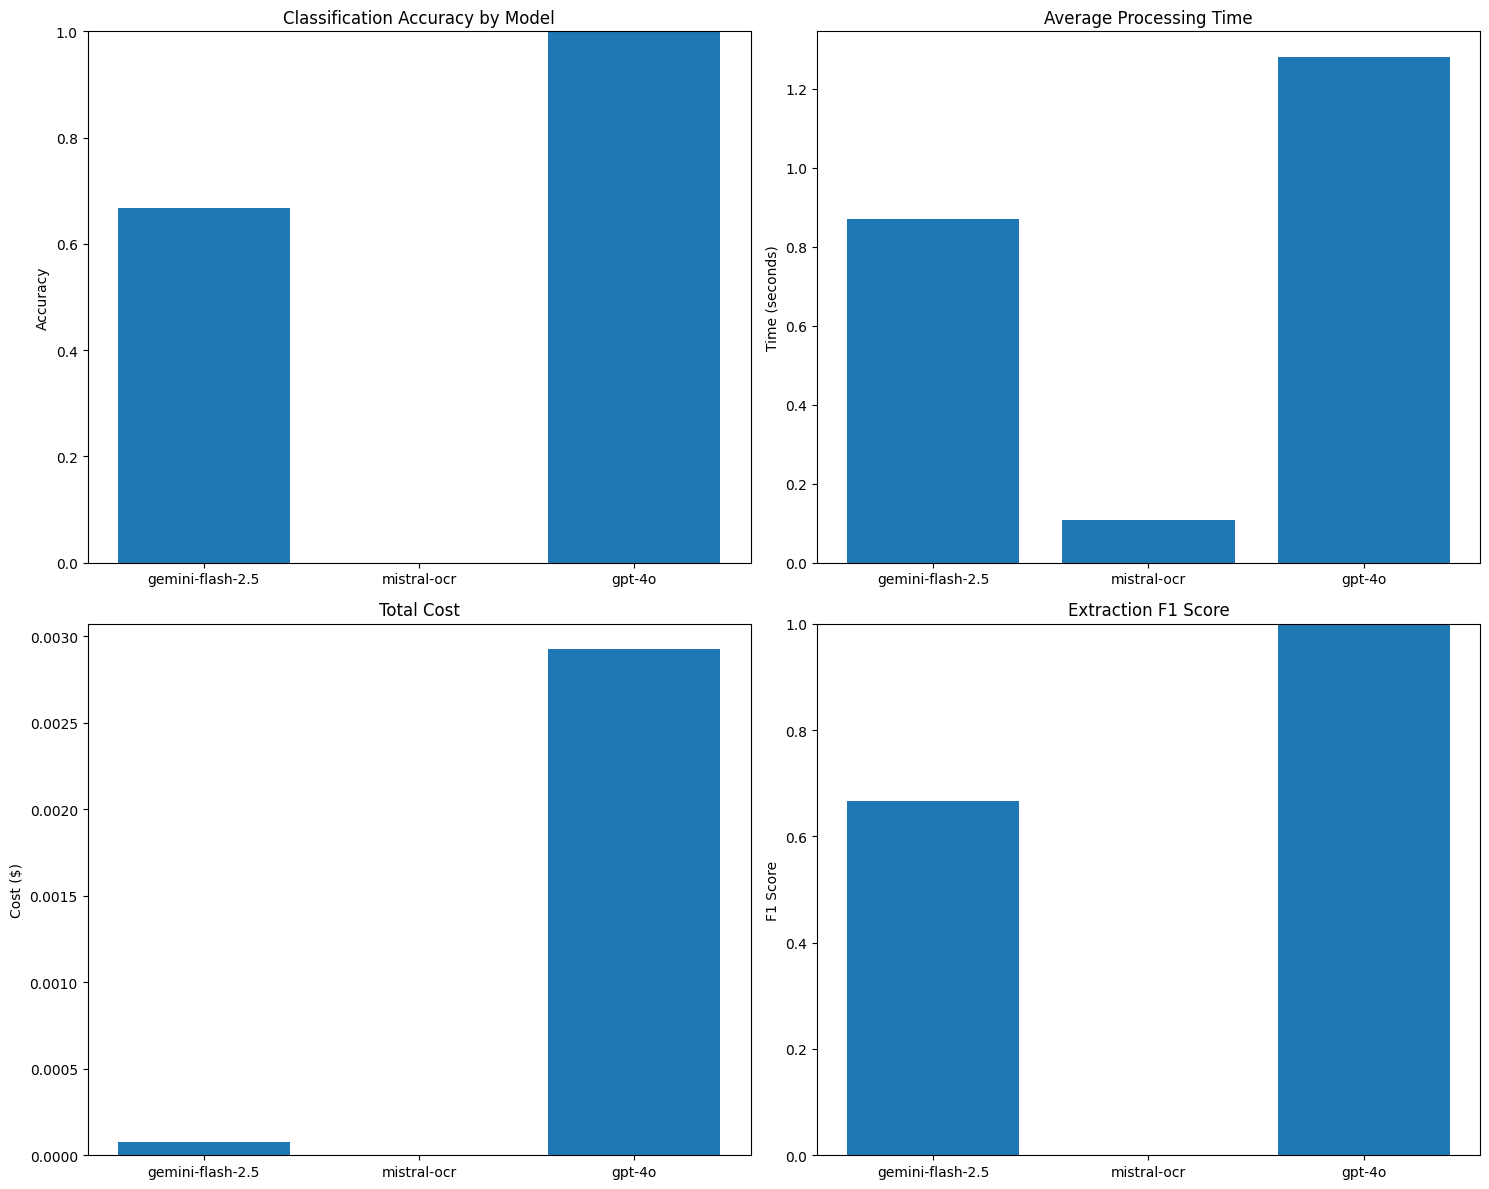

In [13]:
# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
ax1.bar(results_df['model_name'], results_df['category_accuracy'])
ax1.set_title('Classification Accuracy by Model')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)

# Processing time comparison
ax2.bar(results_df['model_name'], results_df['avg_processing_time'])
ax2.set_title('Average Processing Time')
ax2.set_ylabel('Time (seconds)')

# Cost comparison
ax3.bar(results_df['model_name'], results_df['total_cost'])
ax3.set_title('Total Cost')
ax3.set_ylabel('Cost ($)')

# F1 Score comparison
ax4.bar(results_df['model_name'], results_df['extraction_f1'])
ax4.set_title('Extraction F1 Score')
ax4.set_ylabel('F1 Score')
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
def run_benchmark(model_name, test_cases):
    print(f"\nBenchmarking {model_name}...")
    
    predictions = []
    true_labels = []
    processing_times = []
    costs = []
    errors = 0
    
    for case in tqdm(test_cases, desc=f"Processing {model_name}"):
        try:
            start_time = time.time()
            result = client.classify_and_extract(
                file_base64=case['file_base64'], 
                model_name=model_name
            )
            
            predictions.append(result.category.value)
            true_labels.append(case['category'])
            processing_times.append(result.processing_time or 0)
            costs.append(result.cost or 0)
            
        except Exception as e:
            print(f"Error with {model_name}: {e}")
            predictions.append('other')
            true_labels.append(case['category'])
            processing_times.append(0)
            costs.append(0)
            errors += 1
            
        # Rate limiting
        time.sleep(1)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    avg_time = np.mean(processing_times)
    total_cost = sum(costs)
    error_rate = errors / len(test_cases)
    
  
        model_name=model_name,
        category_accuracy=accuracy,
        extraction_f1=f1,
        avg_processing_time=avg_time,
        total_cost=total_cost,
        samples_processed=len(test_cases),
        error_rate=error_rate
    ) predictions, true_labels

# Run benchmarks
benchmark_results = {}
all_predictions = {}
all_true_labels = {}

for model in models_to_test:
    try:
        result, preds, true_labs = run_benchmark(model, synthetic_test_cases)
        benchmark_results[model] = result
        all_predictions[model] = preds
        all_true_labels[model] = true_labs
    except Exception as e:
        print(f"Failed to benchmark {model}: {e}")


Benchmarking gemini-flash-2.5...


Processing gemini-flash-2.5:   0%|          | 0/3 [00:00<?, ?it/s]

Error with gemini-flash-2.5: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing gemini-flash-2.5:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

Error with gemini-flash-2.5: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing gemini-flash-2.5:  67%|██████▋   | 2/3 [00:02<00:01,  1.01s/it]

Error with gemini-flash-2.5: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing gemini-flash-2.5: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]



Benchmarking mistral-ocr...


Processing mistral-ocr:   0%|          | 0/3 [00:00<?, ?it/s]

Error with mistral-ocr: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing mistral-ocr:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

Error with mistral-ocr: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing mistral-ocr:  67%|██████▋   | 2/3 [00:02<00:01,  1.01s/it]

Error with mistral-ocr: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing mistral-ocr: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]



Benchmarking gpt-4o...


Processing gpt-4o:   0%|          | 0/3 [00:00<?, ?it/s]

Error with gpt-4o: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing gpt-4o:  33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

Error with gpt-4o: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing gpt-4o:  67%|██████▋   | 2/3 [00:02<00:01,  1.01s/it]

Error with gpt-4o: OpenRouterClient.classify_and_extract() got an unexpected keyword argument 'file_base64'


Processing gpt-4o: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


## Summary and Recommendations

In [15]:
# Find best model for each metric
best_accuracy = results_df.loc[results_df['category_accuracy'].idxmax()]
best_speed = results_df.loc[results_df['avg_processing_time'].idxmin()]
best_cost = results_df.loc[results_df['total_cost'].idxmin()]

print("\n=== BENCHMARK SUMMARY ===")
print(f"Best Accuracy: {best_accuracy['model_name']} ({best_accuracy['category_accuracy']:.3f})")
print(f"Fastest: {best_speed['model_name']} ({best_speed['avg_processing_time']:.3f}s)")
print(f"Most Cost-Effective: {best_cost['model_name']} (${best_cost['total_cost']:.4f})")

print("\n=== RECOMMENDATIONS ===")
print("• For production use: Choose model with best accuracy-cost balance")
print("• For high-volume processing: Consider fastest model")
print("• For budget constraints: Use most cost-effective model")


=== BENCHMARK SUMMARY ===
Best Accuracy: gpt-4o (1.000)
Fastest: mistral-ocr (0.109s)
Most Cost-Effective: mistral-ocr ($0.0000)

=== RECOMMENDATIONS ===
• For production use: Choose model with best accuracy-cost balance
• For high-volume processing: Consider fastest model
• For budget constraints: Use most cost-effective model


In [16]:
# Save results
results_df.to_csv('benchmark_results.csv', index=False)
print("\nResults saved to benchmark_results.csv")


Results saved to benchmark_results.csv
